Florida Atlantic University - CAP 4630 - Intro. to A.I. <br>
Dr. Marques <br>
July 9, 2023 <br>
Amparo Godoy Pastore

# Project 3: TSP using AC

## Introduction

The Traveling Salesman Problem (TSP) is a classic optimization problem that involves finding the shortest route for a salesman to visit a set of cities and return to the starting city. As the number of cities increases, the search space grows exponentially, making it computationally challenging to find the optimal solution.

In this project, we will tackle the TSP using the Ant Colony Optimization (ACO) algorithm. ACO draws inspiration from the natural foraging behavior of ants and leverages their ability to find efficient routes between food sources. The key idea behind ACO is the utilization of pheromone trails. Ants deposit pheromone on the paths they travel, and they are attracted to paths with higher pheromone concentration. This pheromone-based communication allows ants to gradually converge towards the food source.

Throughout this project, we will implement the ACO algorithm, and apply it to solve various instances of the TSP. Our aim is to obtain near-optimal solutions for the TSP.


**The Problem:**

<div class="alert alert-block alert-danger" align="center">
    <b>“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”</b>
</div>


This implementation of ACO to solve the TSP is inspired by Nishant Rodrigues' solution (see references). For this solution to the problem, we enter a number of cities, and the program randomly generates their coordinates within an (x, y)
plane of 200-by-200. If no nubmer of cities is entered, it will default to 25 cities.The parameters the algorithm takes are explained below in more detail.

## Preliminaries

In [108]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, math, matplotlib.animation as animation, csv
from IPython.display import Image

# Global seed
random.seed(123)

## Cities

***How were the cities and distances represented (as a data structure)***

The cities the salesman travels to are represented using a class called `City`. It has three main attributes: `x`, `y`, and `id`. The `x` and `y` attributes represent the coordinates of the city on a 2D plane, defining its position within the geographical space. The `id` attribute serves as a unique identifier for each city, allowing easy identification and differentiation among multiple cities. It also has a `distance` function that utilizes the Euclidean distance formula to calculate the straight-line distance between two cities based on their coordinates.

The function `generate_cities` creates a specified number of cities with random coordinates within a defined range. The purpose is to generate the initial data, a set of random cities, that will be used as input for the TSP.

In [74]:
class City:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
        
    def distance(self, city):
        # Calculate the distance between two cities
        x_dis = abs(self.x - city.x)
        y_dis = abs(self.y - city.y)
        distance = np.sqrt((x_dis ** 2) + (y_dis ** 2))
        return distance
    
    def __repr__(self):
        # Return a tuple representation of the City object
        return "({0}, {1})".format(self.x, self.y)

In [75]:
def generate_cities(num_cities=25, set_seed=True):
    if set_seed:
        random.seed(3)
    cities = []
    for i in range(0, num_cities):
        # Create a City object with random coordinates and an ID
        cities.append(City(x=int(random.random()*200), y=int(random.random()*200), id=int(i)))
    return cities

## Edges

An edge represents the connection between two cities. Each Edge object holds information about the two connected cities (a and b), the weight or distance of the edge, and the initial pheromone level.

In [76]:
class Edge:
    def __init__(self, a, b, weight, initial_pheromone):
        self.a = a
        self.b = b
        self.weight = weight
        self.pheromone = initial_pheromone

## Ants

Here we define the `Ant` class, representing an agent in the ACO algorithm. 

The `Ant` class has the following attributes:

- `alpha` and `beta`: Parameters influencing the ant's decision-making during city selection.
- `num_cities`: The total number of cities in the TSP problem.
- `edges`: Connections between cities.
- `route`: The sequence of cities visited by the ant.
- `distance`: The total distance traveled by the ant along its route.

The `select_city()` function implements the selection of the next city to visit based on pheromone levels and the heuristic information (distance) to calculate a probability distribution and select a city. This method is iteratively called by the `find_route()` function to construct a complete route. Finally, `get_distance()` calculates the total distance of the ant's route by summing the weights of the edges between consecutive cities.

In [139]:
class Ant:
    def __init__(self, alpha, beta, num_cities, edges):
        self.alpha = alpha
        self.beta = beta
        self.num_cities = num_cities
        self.edges = edges
        self.route = None
        self.distance = 0.0
        
    def select_city(self):
        # Select the next city to visit using the ACS algorithm
        roulette_wheel = 0.0
        unvisited_cities = [city for city in range(self.num_cities) if city not in self.route]
        heuristic_total = 0.0
        for unvisited_city in unvisited_cities:
            heuristic_total += self.edges[self.route[-1]][unvisited_city].weight
        for unvisited_city in unvisited_cities:
            roulette_wheel += pow(self.edges[self.route[-1]][unvisited_city].pheromone, self.alpha) * \
                              pow((heuristic_total / self.edges[self.route[-1]][unvisited_city].weight), self.beta)
        random_value = random.uniform(0.0, roulette_wheel)
        wheel_position = 0.0
        for unvisited_city in unvisited_cities:
            wheel_position += pow(self.edges[self.route[-1]][unvisited_city].pheromone, self.alpha) * \
                              pow((heuristic_total / self.edges[self.route[-1]][unvisited_city].weight), self.beta)
            if wheel_position >= random_value:
                return unvisited_city

    def find_route(self):
        # Find a complete route by iteratively selecting cities to visit
        self.route = [random.randint(0, self.num_cities - 1)]
        while len(self.route) < self.num_cities:
            self.route.append(self.select_city())
        return self.route

    def get_distance(self):
        # Calculate the total distance of the route
        self.distance = 0.0
        for i in range(self.num_cities):
            self.distance += self.edges[self.route[i]][self.route[(i + 1) % self.num_cities]].weight
        return self.distance

## Ant Colony Optimization

The Ant Colony System (ACS) algorithm begins by randomly placing a group of artificial ants at different cities. 

***How did you encode the solution space?***

Each ant constructs a route, representing a feasible solution to the TSP. The ant determines the next city to visit by following a state transition rule, known as the greedy rule. This rule strikes a balance between exploring new edges and exploiting the accumulated knowledge of previously visited cities.

***Which strategy(ies) did you use to compute the best solution?***

During the construction of the tour, each ant deposits a fixed amount of pheromone on the edges of the best route discovered so far. This encourages other ants to follow the same path. By doing so, the ACS algorithm utilizes the collective intelligence of the ant colony to guide the search towards a promising solution.

If an ant finds a shorter route than the current global best route, it becomes the new best route.

***What other parameters, design choices, initialization, and configuration steps are relevant to your design and implementation?***

The `ACO` class executes the ACO algorithm. This method takes the following parameters

- `colony_size`: The number of ants in the colony. Defaults to 10.
- `alpha` and `beta`: Parameters controlling the balance between pheromone and heuristic information in ant decision-making. Default to 1.0 and 3.0, respectively.
- `rho`: The evaporation rate of pheromone. Deafults to 0.1.
- `pheromone_deposit_weight`: The weight of deposited pheromone on the edges. Default is 1.0.
- `initial_pheromone`: The initial pheromone value on each edge. Default is 1.0.
- `steps`: The number of iterations/steps for the algorithm. Defaults to 100.
- `cities`: A list of City objects representing the cities.

An instance of the `ACO` can be run and plotted by calling the following functions:

- `run(print_results=True)`: Runs the ACO algorithm and optionally prints the results, including the optimal route and its distance.
- `plot(plot_route=True, color1='blue', color2='red')`: Visualizes the cities and (optionally) the optimal route found by the ACO algorithm using Matplotlib.

***How did you handle the creation of the initial ant population?***

The initial ant population is created in the ACO class constructor. A specified number of ants are created, and each ant is initialized with random routes.

***How did you handle the updating of the pheromone trails?***

After each iteration, the pheromone trails are updated based on the routes constructed by the ants. The amount of pheromone deposited on an edge is inversely proportional to the distance of the route.

***Which stopping condition did you use? Why?***

The stopping condition is a fixed number of iterations (`steps`). The algorithm performs the specified number of iterations and termiantes. This stopping condition was chosen for simplicity in this implementation, but other stopping conditions such as reaching a certain threshold improvement could also be used.



In [144]:
class ACO:
    def __init__(self, colony_size=10, alpha=1.0, beta=3.0, rho=0.1, pheromone_deposit_weight=1.0,
                 initial_pheromone=1.0, steps=100, cities=None):
        self.colony_size = colony_size  # Number of ants in the colony
        self.alpha = alpha  # Alpha parameter for balancing pheromone and heuristic information
        self.beta = beta  # Beta parameter for balancing pheromone and heuristic information
        self.rho = rho  # Parameter for pheromone evaporation
        self.pheromone_deposit_weight = pheromone_deposit_weight  # Weight of deposited pheromone
        self.initial_pheromone = initial_pheromone  # Initial pheromone value on each edge
        self.steps = steps  # Number of iterations/steps for the algorithm
        self.num_cities = len(cities)  # Total number of cities
        self.cities = cities  # List of City objects representing the cities

        # Create a 2D array to represent the edges between cities
        self.edges = [[None] * self.num_cities for _ in range(self.num_cities)]
        for i in range(self.num_cities):
            for j in range(i + 1, self.num_cities):
                distance = self.cities[i].distance(self.cities[j])  # Calculate the distance between two cities
                self.edges[i][j] = self.edges[j][i] = Edge(i, j, distance, initial_pheromone)

        # Initialize the ant population
        self.ants = [Ant(alpha, beta, self.num_cities, self.edges) for _ in range(self.colony_size)]
        self.best_route = None  # Best route found by the ants
        self.best_distance = float("inf")  # Distance of the best route found

    def add_pheromone(self, route, distance, weight=1.0):
        # Deposit pheromone on the edges of the given route
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_cities):
            self.edges[route[i]][route[(i + 1) % self.num_cities]].pheromone += weight * pheromone_to_add

    def acs(self):
        # Run the Ant Colony System algorithm
        for step in range(self.steps):
            for ant in self.ants:
                self.add_pheromone(ant.find_route(), ant.get_distance())  # Update pheromone and find routes for ants
                if ant.distance < self.best_distance:
                    self.best_route = ant.route  # Update the best route if a shorter route is found
                    self.best_distance = ant.distance  # Update the best distance
            for i in range(self.num_cities):
                for j in range(i + 1, self.num_cities):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)  # Evaporate pheromone on all edges

    def run(self, print_results=True):
        # Run the ACO algorithm and optionally print the results
        if print_results:
            print('ACO Algorithm Parameters:\n')
            print('Number of Cities: {0}'.format(self.num_cities))
            print('Colony Size: {0}'.format(self.colony_size))
            print('Alpha: {0}'.format(self.alpha))
            print('Beta: {0}'.format(self.beta))
            print('Rho: {0}'.format(self.rho))
            print('Pheromone Deposit Weight: {0}'.format(self.pheromone_deposit_weight))
            print('Initial Pheromone: {0}'.format(self.initial_pheromone))
            print('Number of Steps: {0}'.format(self.steps))
            print('----------------------------------\n')

        self.acs()  # Run the ACO algorithm
        if print_results:
            print('Route distance: {0}'.format(round(self.best_distance, 2)))
            print('Optimal route: {0}'.format(', '.join(str(city_index) for city_index in self.best_route)))

    def plot(self, plot_route=True, color1='blue', color2='red'):
        x = [self.cities[i].x for i in self.best_route] + [self.cities[self.best_route[0]].x]
        y = [self.cities[i].y for i in self.best_route] + [self.cities[self.best_route[0]].y]
        
        plt.scatter(x, y, color=color2)  # Plot the cities as dots
        plt.title('Cities')
        
        if plot_route:
            plt.plot(x, y, color=color1, linestyle='-')  # Plot the optimal route
            plt.title('TSP with ACO: Optimal Route')

        plt.xticks([])
        plt.yticks([])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        
        for i, city_id in enumerate(self.best_route):
            plt.text(self.cities[city_id].x, self.cities[city_id].y, str(city_id), ha='center', va='bottom')

        plt.show()

## First Run

Here we test the ACO algorithm with the default 25 cities. We set the colony to 100 ants, steps to 50, and keep the default values of the other parameters.

ACO Algorithm Parameters:

Number of Cities: 25
Colony Size: 100
Alpha: 1.0
Beta: 3.0
Rho: 0.1
Pheromone Deposit Weight: 1.0
Initial Pheromone: 1.0
Number of Steps: 50
----------------------------------

Route distance: 870.02
Optimal route: 21, 7, 2, 10, 18, 20, 5, 13, 6, 11, 14, 15, 8, 24, 17, 16, 9, 1, 23, 0, 3, 19, 4, 12, 22


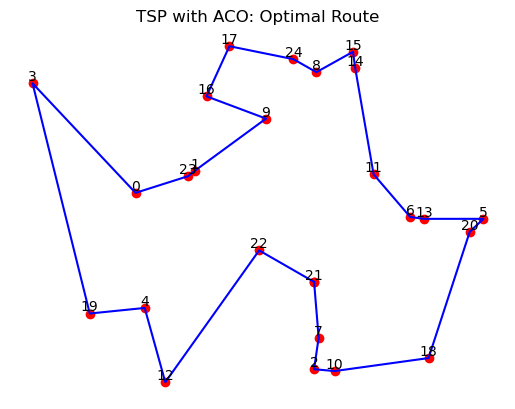

In [145]:
if __name__ == '__main__':
    
    params = {
        'colony_size': 100,
        'steps': 50,
        'cities': generate_cities() # Default 25
    }
    
    acs = ACO(**params)
    acs.run()
    acs.plot()

After executing the algorithm for 50 steps, the optimal route with the shortest distance was found to be 870.02. The route itself traversed the cities in the following order: 21, 7, 2, 10, 18, 20, 5, 13, 6, 11, 14, 15, 8, 24, 17, 16, 9, 1, 23, 0, 3, 19, 4, 12, 22. 

These results above demonstrate the ACO algorithm was able to find an optimized route that minimized the distance traveled among the given set of cities. This indicates it is effective in solving the traveling salesman problem.

## Testing

***Which (simple) experiments have you run to observe the impact of different design decisions and parameter values? Post their results and your comments***

Lastly, we will conduct some tests on the ACO algorithm. Here we explore the performance of the algorithm by running it with five different parameter configurations **on 20 cities**. By varying parameters such as colony size, alpha, beta, rho, pheromone deposit weight, initial pheromone, and steps, the code evaluates how these settings impact the algorithm's ability to find optimal solutions for the given problem domain. The results are recorded and saved to a CSV file.

Further testing could focus on isolating each parameter to evaluate its impact, however, we are only testing 5 parameter configurations for the sake of simplicity. 

In [149]:
# Randomizing a list of 10 cities
cities = generate_cities(20)

# Define the parameter configurations to test
params = [
    {'colony_size': 10, 'alpha': 1.0, 'beta': 3.0, 'rho': 0.1, 'pheromone_deposit_weight': 1.0, 'initial_pheromone': 1.0, 'steps': 100},
    {'colony_size': 20, 'alpha': 2.0, 'beta': 2.0, 'rho': 0.2, 'pheromone_deposit_weight': 0.8, 'initial_pheromone': 0.5, 'steps': 200},
    {'colony_size': 30, 'alpha': 3.0, 'beta': 1.0, 'rho': 0.3, 'pheromone_deposit_weight': 0.6, 'initial_pheromone': 0.2, 'steps': 300},
    {'colony_size': 15, 'alpha': 1.5, 'beta': 2.5, 'rho': 0.15, 'pheromone_deposit_weight': 0.9, 'initial_pheromone': 0.8, 'steps': 150},
    {'colony_size': 25, 'alpha': 2.5, 'beta': 1.5, 'rho': 0.25, 'pheromone_deposit_weight': 0.7, 'initial_pheromone': 0.4, 'steps': 250}
]


# Run the ACO algorithm for each parameter configuration
results = []
for config in params:
    aco = ACO(cities=cities, **config)  # Assuming my_cities is a list of City objects
    aco.run(print_results=False)
    results.append({'Colony Size': aco.colony_size, 'Alpha': aco.alpha, 'Beta': aco.beta,
                    'Rho': aco.rho, 'Pheromone Deposit Weight': aco.pheromone_deposit_weight,
                    'Initial Pheromone': aco.initial_pheromone, 'Steps': aco.steps,
                    'Best Distance': aco.best_distance, 'City IDs': ','.join(map(str, aco.best_route))})

# Save the results to a CSV file
csv_filename = 'aco_results.csv'
fieldnames = ['Colony Size', 'Alpha', 'Beta', 'Rho', 'Pheromone Deposit Weight', 'Initial Pheromone',
              'Steps', 'Best Distance', 'City IDs']
with open(csv_filename, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f'Results saved to {csv_filename}.')

Results saved to aco_results.csv.


The following results indicate the best distance achieved by the algorithm ranges from approximately 789.81 to 800.62, with lower values indicating better performance. Runs 0 and 1, as well as runs 2 and 4, produced the same best distance. 

Overall, the ACO algorithm demonstrates consistent performance in finding near-optimal routes across various parameter configurations. The choice of parameters, such as colony size, alpha, beta, rho, pheromone deposit weight, initial pheromone, and steps, can influence the outcome but not significantly. 

In [150]:
# Read and display the CSV file
df = pd.read_csv('aco_results.csv')
df

,Colony Size,Alpha,Beta,Rho,Pheromone Deposit Weight,Initial Pheromone,Steps,Best Distance,City IDs
0,10,1.0,3.0,0.10,1.0,1.0,100,789.813605,"17,16,9,8,15,14,11,6,13,5,18,10,2,7,12,4,19,0,1,3"
1,20,2.0,2.0,0.20,0.8,0.5,200,789.813605,"17,16,9,8,15,14,11,6,13,5,18,10,2,7,12,4,19,0,1,3"
2,30,3.0,1.0,0.30,0.6,0.2,300,800.369016,"11,13,6,5,18,10,2,7,12,4,19,0,1,3,17,16,9,8,15,14"
3,15,1.5,2.5,0.15,0.9,0.8,150,796.566504,"1,0,19,4,12,7,2,10,18,5,13,6,11,15,14,8,9,16,17,3"
4,25,2.5,1.5,0.25,0.7,0.4,250,800.620513,"16,9,8,14,15,11,6,13,5,18,7,10,2,12,4,19,0,1,3,17"


## Future Improvements

Two potential areas of future improvement are:

1. Pheromone Update: Experimenting with the MAX-MIN Ant System (MMAS) or the Rank-Based Ant System (ASrank), may lead to better convergence and performance of the algorithm.


2. Large-Scale Optimization: Developing techniques to handle large-scale TSP instances, such as divide-and-conquer, clustering methods, or sub-tour elimination algorithms, could help extend the algorithm's applicability to real-world scenarios with a larger number of cities.

## References

- Marín Cantero, Y.A. (n.d.). Implementing Ant Colony Optimization (ACO) algorithm for a given Symmetric traveling salesman problem (TSP) [GitHub repository]. Retrieved from https://github.com/yammadev/aco-tsp


- nishnash54. (n.d.). Traveling Salesman Problem using Ant Colony Optimization [GitHub repository]. Retrieved from https://github.com/nishnash54/TSP_ACO


- rochakgupta. (n.d.). Solving Travelling Salesman Problem using Ant Colony Optimization [GitHub repository]. Retrieved from https://github.com/rochakgupta/aco-tsp


- Hurbans, R. (2020). Grokking Artificial Intelligence Algorithms. Simon and Schuster.